# Environment Setup

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Question 3: Coin Detection in Mario Maps

## Task 1: Pre-Processing


#### Task 1 Functions

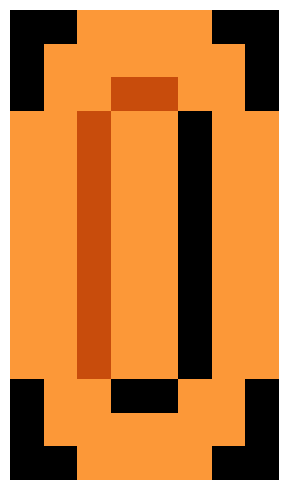

In [31]:
coin = cv2.imread('mario_pics/coin.png')
plt.figure(figsize=(10, 5))

plt.imshow(cv2.cvtColor(coin, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

#### Cropping

I managed to achieve 100% accuracy without adapting the template image.
I was focusing on cropping a very tight coin image in order to limit the background pixels appearing in the template since the background in not in the same color across all the maps.

## Task 2: Template Matching Methods


#### SAD — Sum of Absolute Differences

In [32]:
def sad_template_matching(source_image_path, template_image_path, threshold=0.2):
    img_source = cv2.imread(source_image_path)
    img_template = cv2.imread(template_image_path)

    img_gray = cv2.cvtColor(img_source, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(img_template, cv2.COLOR_BGR2GRAY)

    img_gray = img_gray.astype(np.float32)
    template_gray = template_gray.astype(np.float32)

    image_h, image_w = img_gray.shape
    template_h, template_w = template_gray.shape

    sad_res = np.zeros((image_h - template_h + 1, image_w - template_w + 1), dtype=np.float32)

    for y in range(image_h - template_h + 1):
        for x in range(image_w - template_w + 1):
            patch = img_gray[y:y + template_h, x:x + template_w]
            sad_score = np.sum(np.abs(patch - template_gray))
            sad_res[y, x] = sad_score

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(sad_res)

    # Normalized results to make threshold between 0 and 1
    sad_res = sad_res / max_val

    loc = np.where(sad_res <= threshold)

    row_indices = loc[0]
    col_indices = loc[1]
    matches_points = list(zip(col_indices, row_indices))

    for pt in matches_points:
        top_left = pt
        bottom_right = (pt[0] + template_w, pt[1] + template_h)
        cv2.rectangle(img_source, top_left, bottom_right, (0, 0, 255), 2)

    print(f"Found {len(matches_points)} matches")

    img_result_rgb = cv2.cvtColor(img_source, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 8))
    plt.imshow(img_result_rgb)
    plt.title(f"{source_image_path}")
    plt.axis("off")
    plt.show()

#### SAD Execution

Found 19 matches


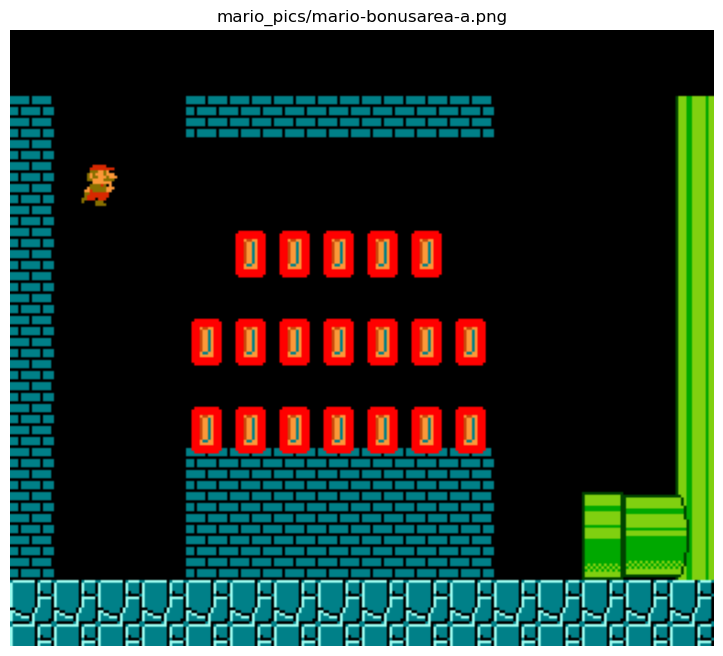

Found 12 matches


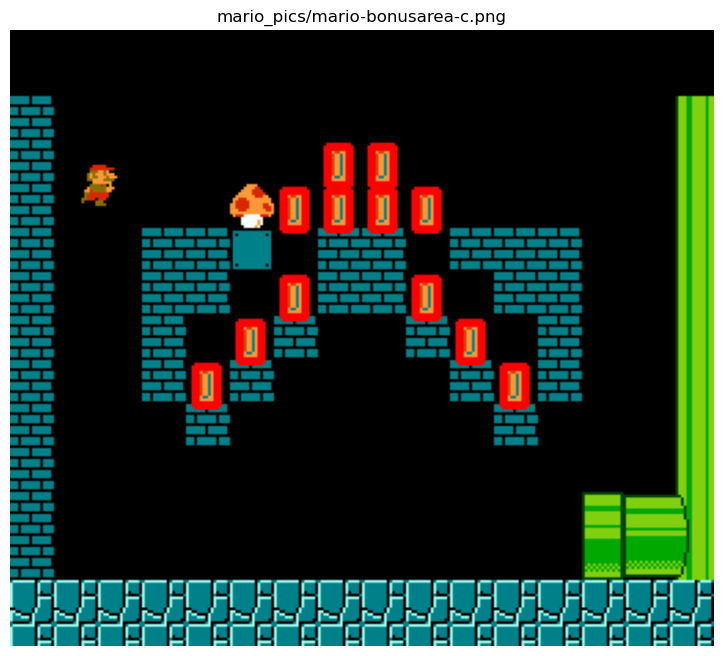

Found 17 matches


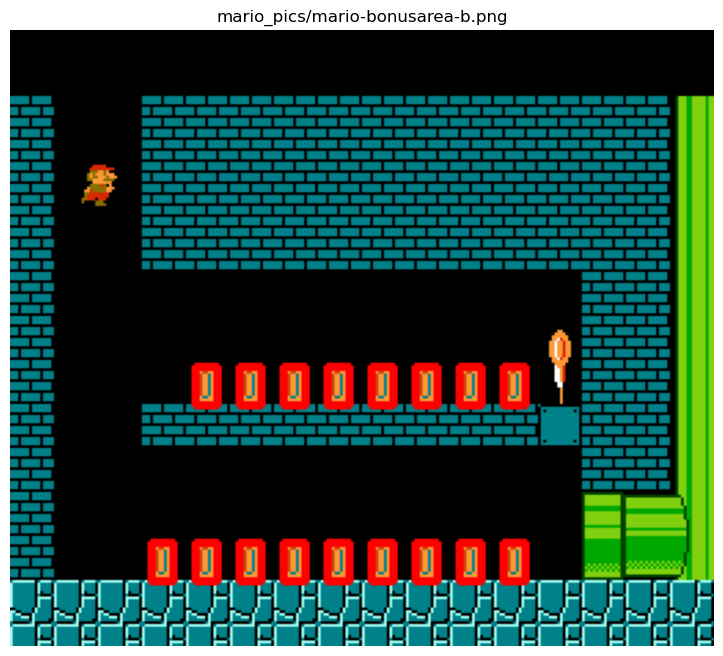

Found 20 matches


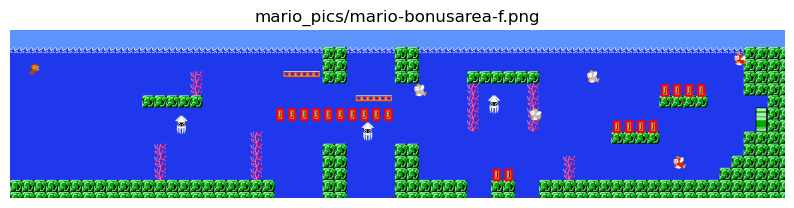

Found 10 matches


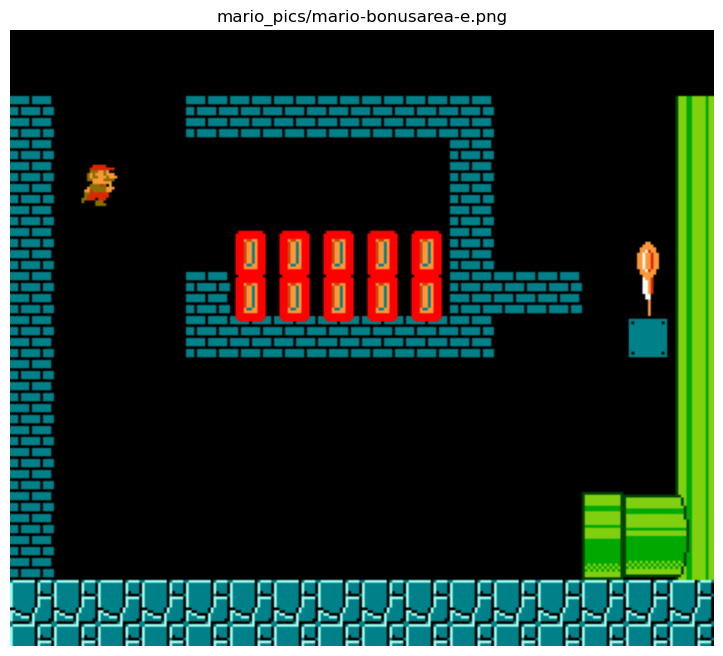

Found 18 matches


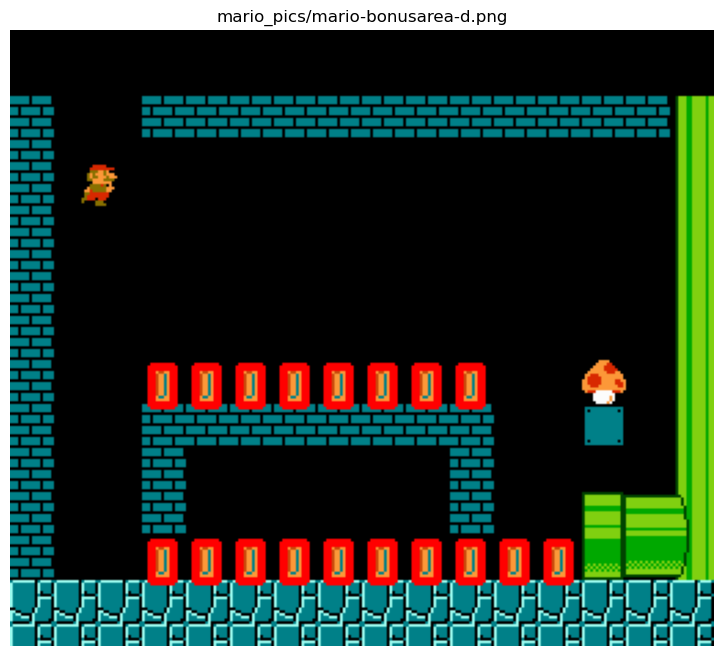

Found 52 matches


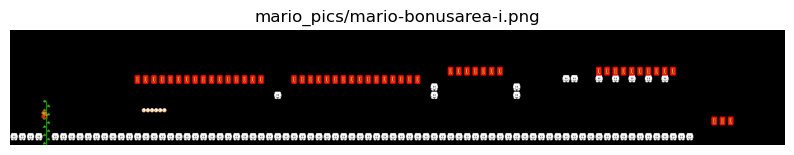

Found 41 matches


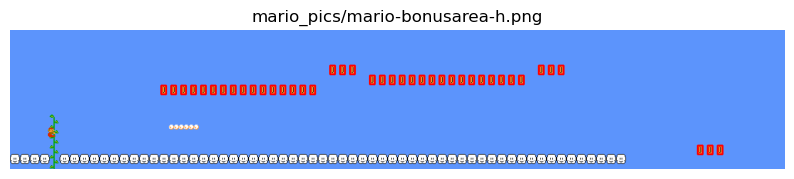

Found 19 matches


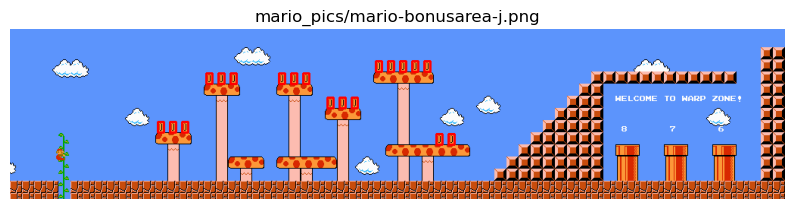

Found 52 matches


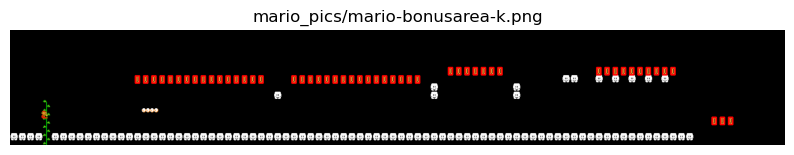

In [33]:
dir = Path('mario_pics')
maps = [str(p) for p in dir.rglob('*') if p.name != "coin.png"]

for m in maps:
    sad_template_matching(m, "mario_pics/coin.png")

#### SAD - Positives and Negatives
- Sensitivity to lighting - SAD computes the Sum of absolute differences of pixel values between the template and the original image so lighting changes will change the pixel values and will cause increase in the computed SAD values which could lead to missed matches or false positives
- Sensitivity to contrast - Contrast also changes the pixel values by multiplying them by some constant. The change will result in higher SAD and such values could lead to missed matches and false positives
- When it fails and why - Any change in pixel intensity which could be caused by lighting or contrast will result in higher SAD and missed matches or false positives. Also, rotation and changes in scales are not handled.

#### SSD — Sum of Squared Differences

In [34]:
def ssd_template_matching(source_image_path, template_image_path, threshold=0.1):
    img_source = cv2.imread(source_image_path)
    img_template = cv2.imread(template_image_path)

    img_gray = cv2.cvtColor(img_source, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(img_template, cv2.COLOR_BGR2GRAY)

    template_w, template_h = template_gray.shape[::-1]
    res = cv2.matchTemplate(img_gray, template_gray, cv2.TM_SQDIFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # Normalized results to make threshold between 0 and 1
    res = res / max_val

    loc = np.where(res <= threshold)
    row_indices = loc[0]
    col_indices = loc[1]
    matches_points = list(zip(col_indices, row_indices))

    for pt in matches_points:
        bottom_right = (pt[0] + template_w, pt[1] + template_h)
        cv2.rectangle(img_source, pt, bottom_right, (0, 0, 255), 2)

    print(f"Found {len(matches_points)} matches")
    img_result_rgb = cv2.cvtColor(img_source, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 8))
    plt.imshow(img_result_rgb)
    plt.title(f"{source_image_path}")
    plt.axis("off")
    plt.show()

#### SSD Execution

Found 19 matches


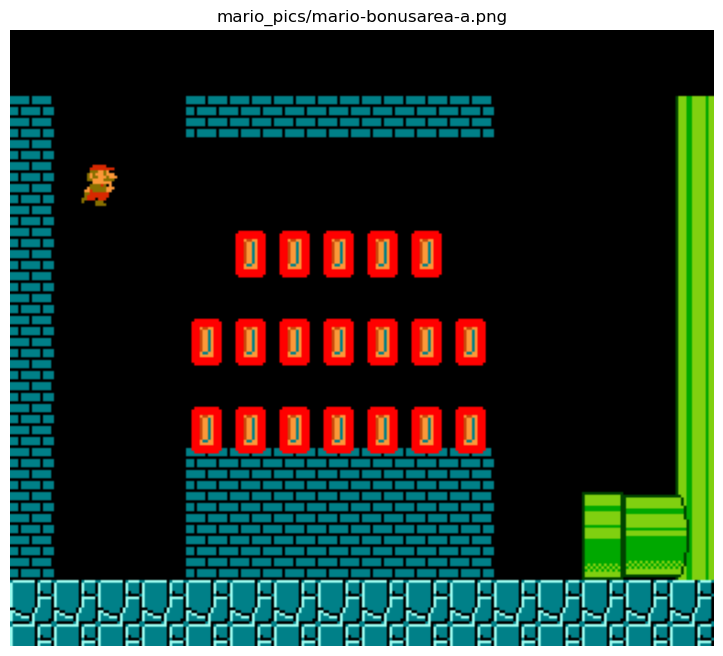

Found 12 matches


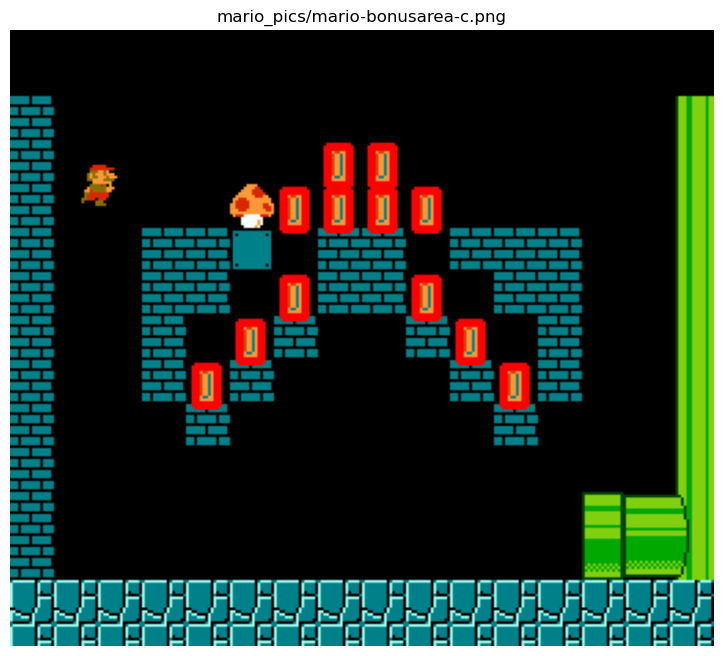

Found 17 matches


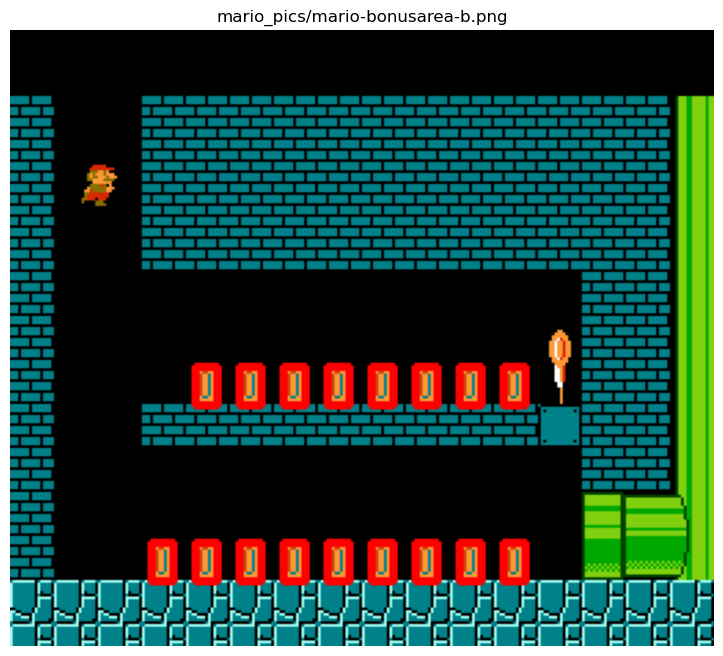

Found 20 matches


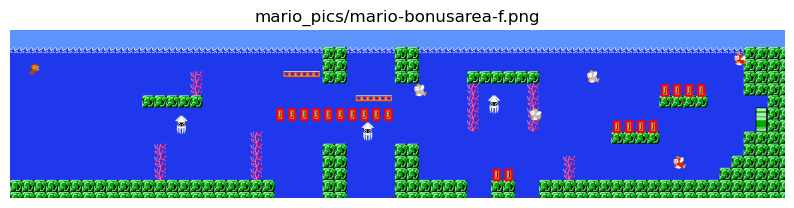

Found 10 matches


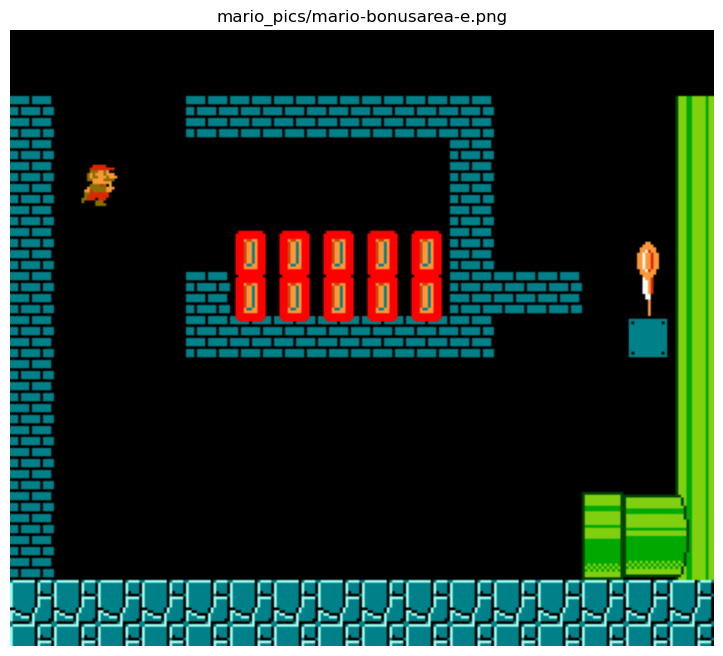

Found 18 matches


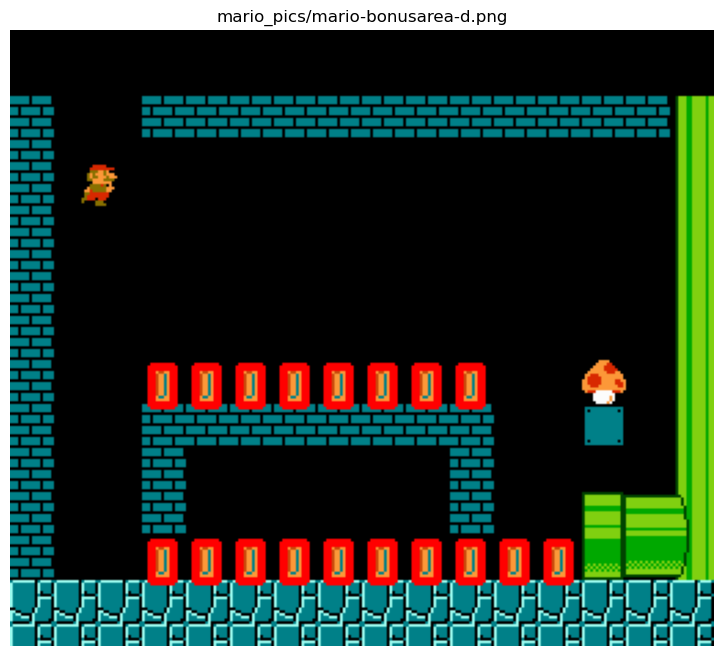

Found 52 matches


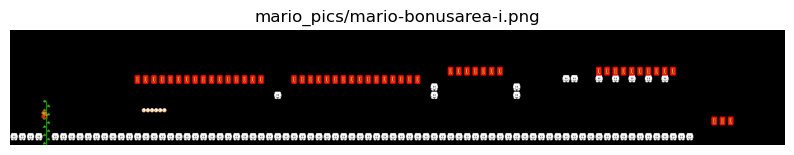

Found 41 matches


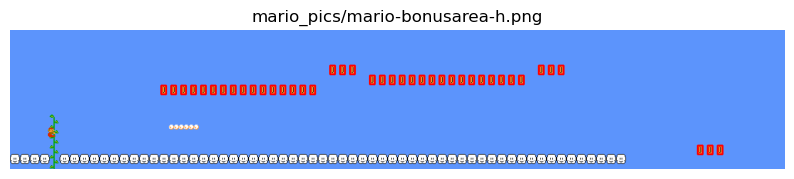

Found 19 matches


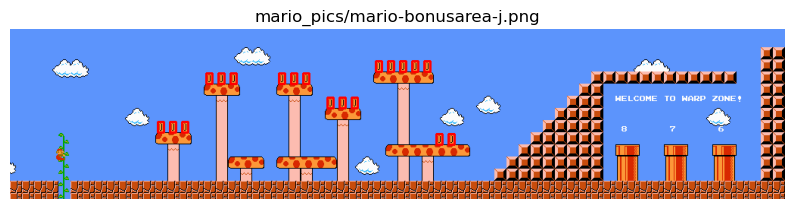

Found 52 matches


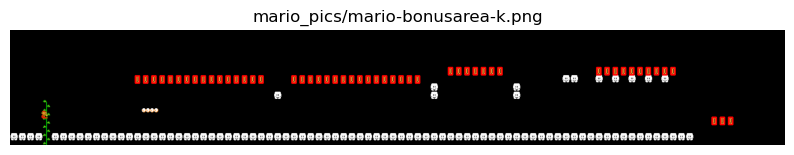

In [35]:
dir = Path('mario_pics')
maps = [str(p) for p in dir.rglob('*') if p.name != "coin.png"]

for m in maps:
    ssd_template_matching(m, "mario_pics/coin.png")


#### SSD - Positives and Negatives
- Sensitivity to lighting - SSD computes the squared differences of pixel values between the template and the original image so lighting changes will change the pixel values and will cause increase in the computed SSD values which could lead to missed matches or false positives
- Sensitivity to contrast - contrast also changes the pixel values by multiplying them by some constant. The change will result in higher SSD values that could lead to missed matches and false positives
- When it fails and why - SSD will give the expected results when the illumination of the template and the image are the same, otherwise there will be pixel values changes which would cause higher SSD and missed matches or false positives. Other image modifications such as rotation and scaling are not handled as well.

#### ZNCC - Zero‑mean Normalized Cross‑Correlation

In [36]:
def zncc_template_matching(source_image_path, template_image_path, threshold=0.8):
    img_source = cv2.imread(source_image_path)
    img_template = cv2.imread(template_image_path)

    img_gray = cv2.cvtColor(img_source, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(img_template, cv2.COLOR_BGR2GRAY)

    template_w, template_h = template_gray.shape[::-1]
    res = cv2.matchTemplate(img_gray, template_gray, cv2.TM_CCOEFF_NORMED)

    loc = np.where(res > threshold)
    row_indices = loc[0]
    col_indices = loc[1]
    matches_points = list(zip(col_indices, row_indices))

    for pt in matches_points:
        bottom_right = (pt[0] + template_w, pt[1] + template_h)
        cv2.rectangle(img_source, pt, bottom_right, (0, 0, 255), 2)

    print(f"Found {len(matches_points)} matches")
    img_result_rgb = cv2.cvtColor(img_source, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 8))
    plt.imshow(img_result_rgb)
    plt.title(f"{source_image_path}")
    plt.axis("off")
    plt.show()

#### ZNCC Execution

Found 19 matches


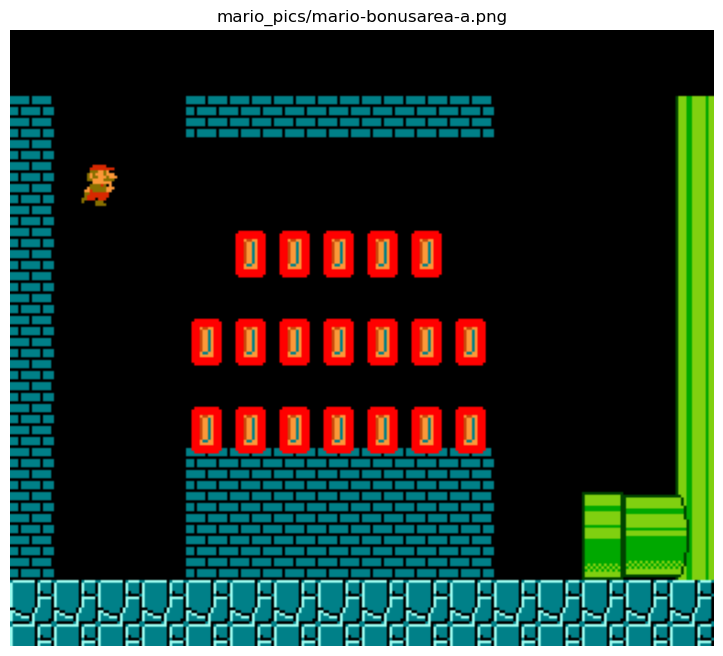

Found 12 matches


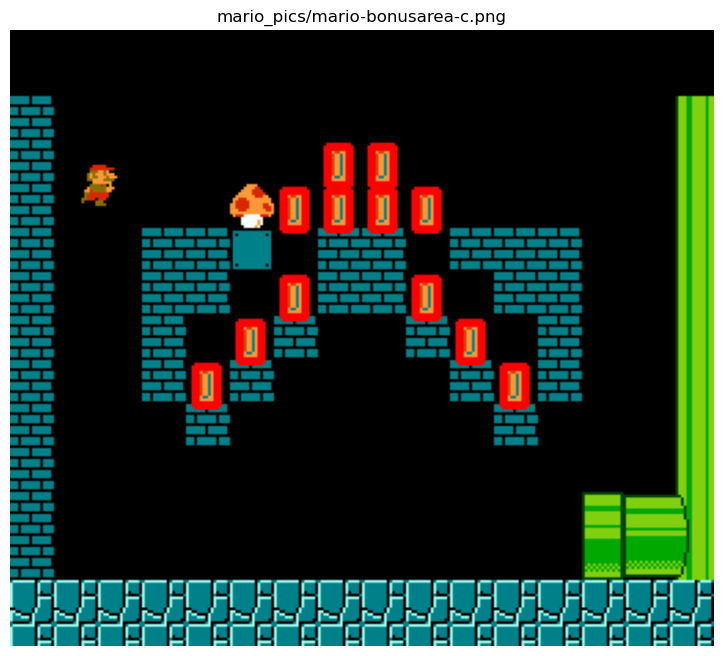

Found 17 matches


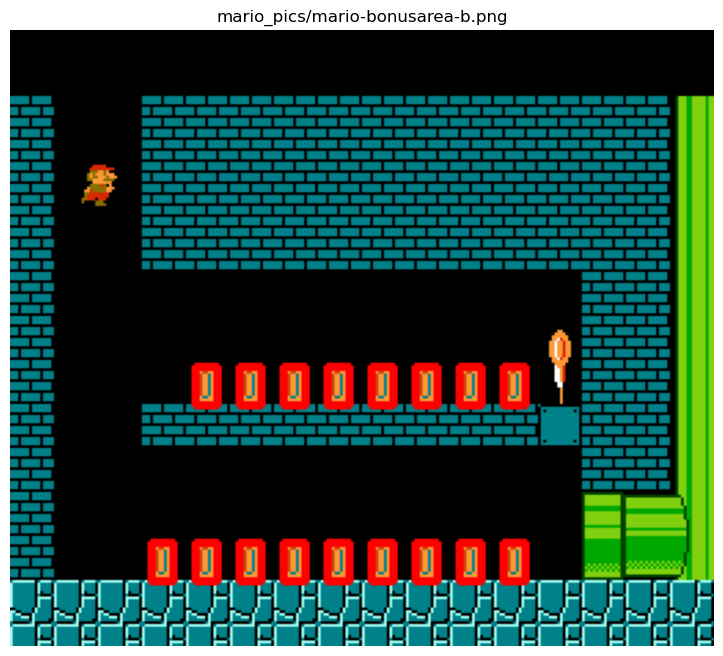

Found 20 matches


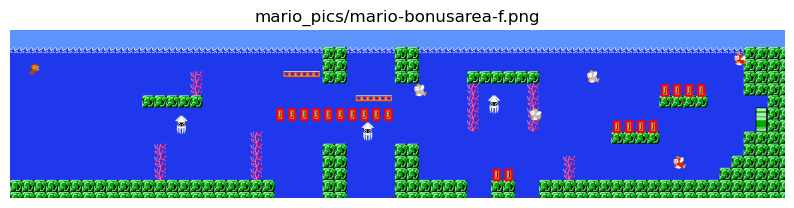

Found 10 matches


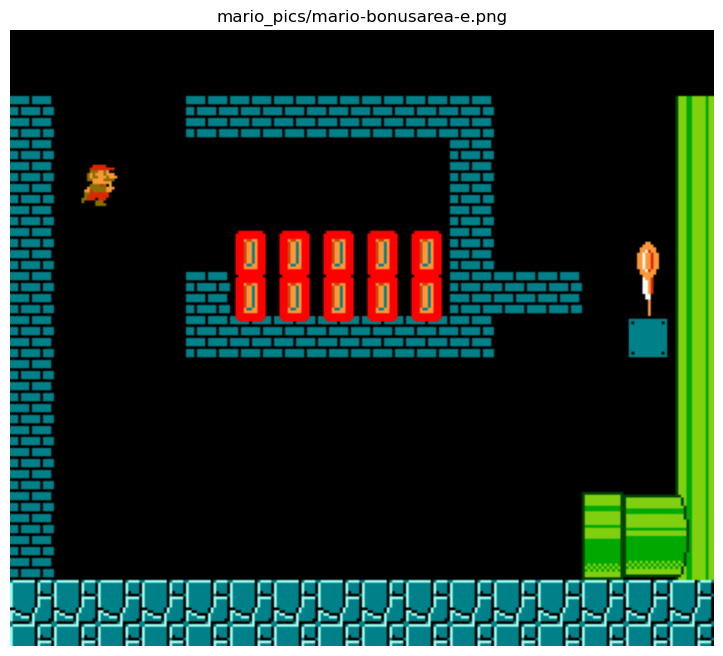

Found 18 matches


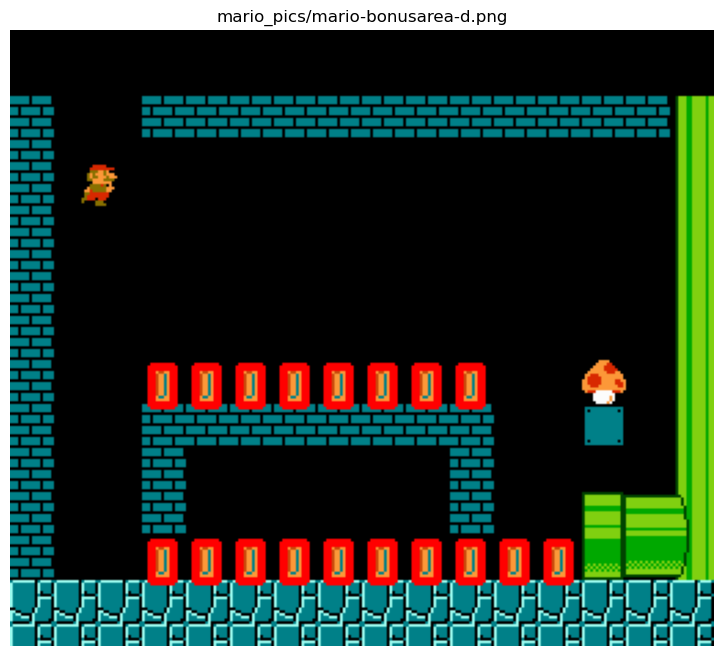

Found 52 matches


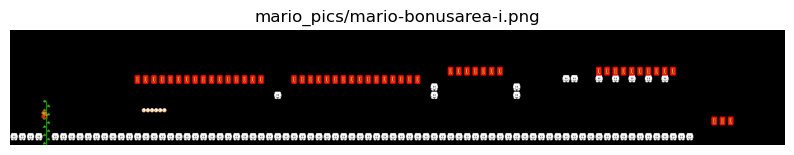

Found 41 matches


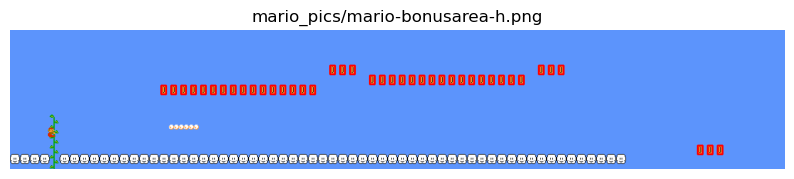

Found 19 matches


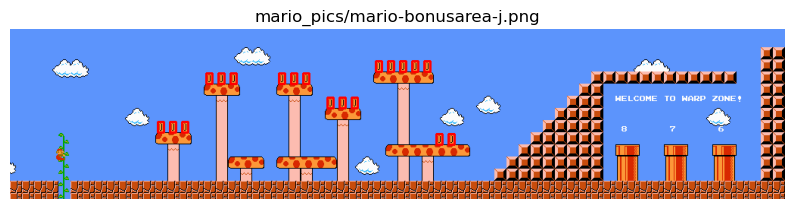

Found 52 matches


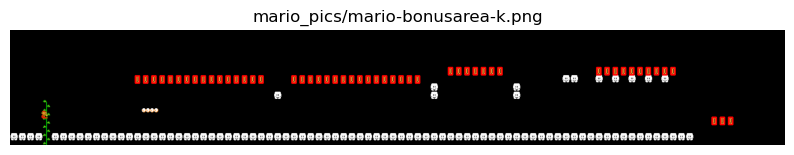

In [37]:
dir = Path('mario_pics')
maps = [str(p) for p in dir.rglob('*') if p.name != "coin.png"]

for m in maps:
    zncc_template_matching(m, "mario_pics/coin.png")


#### ZNCC - Positives and Negatives
- Sensitivity to lighting - ZNCC subtracts the mean intensity from the pixel values so lighting affecting all the image will be normalized during the cross correlation. Lighting affecting only part of the image could result in missed matches or false positives.
- Sensitivity to contrast - ZNCC divided the score by the magnitudes of the template and the image and by doing so it normalized contrast changes. Again, contrast affecting only part of the image will result in missed matches or false positives.
- When it fails and why - ZNCC handles well lighting and contrast affects, but it won't handle scaling and rotation to images or object detection with only part of the object exposed since mismatched pixel values will decrease the correlation between the image and the template.

### Task 3: Coin Detection Evaluation Tables

#### SAD Coin Detection Evaluation Tables

| Map Name | Total Coins (Ground Truth) | Detected | Missed | False Positives | Success Rate (%) |
| :--- | :--- | :--- | :--- | :--- | :--- |
| mario-bonusarea-a.png | 19 | 19 | 0 | 0 | 100% |
| mario-bonusarea-b.png | 12 | 12 | 0 | 0 | 100% |
| mario-bonusarea-c.png | 17 | 17 | 0 | 0 | 100% |
| mario-bonusarea-d.png | 20 | 20 | 0 | 0 | 100% |
| mario-bonusarea-e.png | 10 | 10 | 0 | 0 | 100% |
| mario-bonusarea-f.png | 18 | 18 | 0 | 0 | 100% |
| mario-bonusarea-h.png | 52 | 52 | 0 | 0 | 100% |
| mario-bonusarea-i.png | 41 | 41 | 0 | 0 | 100% |
| mario-bonusarea-j.png | 19 | 19 | 0 | 0 | 100% |
| mario-bonusarea-k.png | 52 | 52 | 0 | 0 | 100% |

#### SSD Coin Detection Evaluation Tables

| Map Name | Total Coins (Ground Truth) | Detected | Missed | False Positives | Success Rate (%) |
| :--- | :--- | :--- | :--- | :--- | :--- |
| mario-bonusarea-a.png | 19 | 19 | 0 | 0 | 100% |
| mario-bonusarea-b.png | 12 | 12 | 0 | 0 | 100% |
| mario-bonusarea-c.png | 17 | 17 | 0 | 0 | 100% |
| mario-bonusarea-d.png | 20 | 20 | 0 | 0 | 100% |
| mario-bonusarea-e.png | 10 | 10 | 0 | 0 | 100% |
| mario-bonusarea-f.png | 18 | 18 | 0 | 0 | 100% |
| mario-bonusarea-h.png | 52 | 52 | 0 | 0 | 100% |
| mario-bonusarea-i.png | 41 | 41 | 0 | 0 | 100% |
| mario-bonusarea-j.png | 19 | 19 | 0 | 0 | 100% |
| mario-bonusarea-k.png | 52 | 52 | 0 | 0 | 100% |

#### ZNCC Coin Detection Evaluation Tables

| Map Name | Total Coins (Ground Truth) | Detected | Missed | False Positives | Success Rate (%) |
| :--- | :--- | :--- | :--- | :--- | :--- |
| mario-bonusarea-a.png | 19 | 19 | 0 | 0 | 100% |
| mario-bonusarea-b.png | 12 | 12 | 0 | 0 | 100% |
| mario-bonusarea-c.png | 17 | 17 | 0 | 0 | 100% |
| mario-bonusarea-d.png | 20 | 20 | 0 | 0 | 100% |
| mario-bonusarea-e.png | 10 | 10 | 0 | 0 | 100% |
| mario-bonusarea-f.png | 18 | 18 | 0 | 0 | 100% |
| mario-bonusarea-h.png | 52 | 52 | 0 | 0 | 100% |
| mario-bonusarea-i.png | 41 | 41 | 0 | 0 | 100% |
| mario-bonusarea-j.png | 19 | 19 | 0 | 0 | 100% |
| mario-bonusarea-k.png | 52 | 52 | 0 | 0 | 100% |